# Image Classification with PyTorch

## Data loading


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms

In [ ]:
# torchvision contains convinience functions for popular datasets
ds_train = datasets.MNIST('data', train=True, download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 131737547.31it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 38565964.29it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 178825345.11it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6312302.44it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Each sample is a 28x28 image

(<PIL.Image.Image image mode=L size=28x28 at 0x7D75927569B0>, 5)


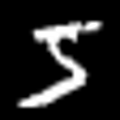

In [ ]:
# if we index this dataset, we get a single data point: a PIL image and an Integer
print(ds_train[0])
ds_train[0][0].resize((120,120))

Let's transform the data to something that our Pytorch models will understand
for this purpose, we can supply a transform function to the datase

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
])
ds_train = datasets.MNIST('data', train=True, download=True, transform=transform)

The image is now a `torch.Tensor`

In [ ]:
type(ds_train[0][0])

torch.Tensor

The normalization is something you learned about in the lecture. Normalizing with $\mu=0, \sigma=1$ corresponds to no normalization. Let's compute the proper normalization constants!

In [ ]:
# lets get only the images
ims_train = ds_train.data
ims_train = ims_train.float() / 255.

In [ ]:
mu = ims_train.mean()
std = ims_train.std()

We normalize the data as below.

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mu, std)
])

# Create the training and testing datasets
ds_train = datasets.MNIST('data', train=True, download=True, transform=transform)
ds_test = datasets.MNIST('data', train=False, download=True, transform=transform)

In [ ]:
ds_train[0][0].min(), ds_train[0][0].max()

(tensor(-0.4241), tensor(2.8215))

Next, we want to receive mini-batches, not only single data points.
We use PyTorch's DataLoader class. Build a dataloader with a batch size of 64 and 4 workers (number of subprocess that peform the dataloading). Important: you need to shuffle the training data, not the test data.

**NOTE**: if you encounter some unexpected errors in data loading, try setting `NUM_WORKERS = 0`

In [ ]:
BATCH_SIZE = 64
NUM_WORKERS = 4

# Create the training and testing dataloaders
dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE,shuffle=True)
dl_test = DataLoader(ds_test, batch_size=BATCH_SIZE,shuffle=True)

## MLP in Pytorch

Ok, the dataloading works. Let's build our model, PyTorch makes this very easy. We will build replicate the model from our last exercises. However, now, we add another variable called `nLayer` that indicates how many linear layers that in your network. Please adapt your code from last exercise accordingly to allow different number of layers.

In [ ]:
# These are the parameters to be used
nInput = 784
nOutput = 10
nLayer = 2
nHidden = 16
act_fn = nn.ReLU()

In [ ]:
class MLP(nn.Module):
    def __init__(self, nInput, nOutput, nLayer, nHidden, act_fn):
        super(MLP, self).__init__()
        layers = [nn.Linear(nHidden, nHidden), act_fn ]*nLayer

        self.model = nn.Sequential(nn.Linear(nInput, nHidden), act_fn, *layers, nn.Linear(nHidden, nOutput) )

    def forward(self, x):
        x = torch.flatten(x, 1)
        return self.model(x)

In [ ]:
# Let's test if the forward pass works
# this should print torch.Size([1, 10])
t = torch.randn(1,1,28,28)
mlp = MLP(nInput, nOutput, nLayer, nHidden, act_fn)
mlp(t).shape

torch.Size([1, 10])

In [ ]:
mlp

MLP(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=10, bias=True)
  )
)

We already implemented the test function for you

In [ ]:
def test(model, dl_test, device='cpu'):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in dl_test:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(dl_test.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        test_loss, correct, len(dl_test.dataset),
        100. * correct / len(dl_test.dataset)))
    return 100. * correct / len(dl_test.dataset)

Now you only need to implement the training and you are good to go

In [ ]:
def train(model, dl_train, optimizer, epoch, log_interval=100, device='cpu'):
    model.train()
    correct = 0
    for batch_idx, (data, target) in enumerate(dl_train):
        data, target = data.to(device), target.to(device)

        # first we need to zero the gradient, otherwise PyTorch would accumulate them
        optimizer.zero_grad()

        y_pred = model(data)
        loss = F.cross_entropy(y_pred, target)
        loss.backward()
        optimizer.step()

        # stats
        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(dl_train.dataset),
                100. * batch_idx / len(dl_train), loss.item()))

    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
        loss, correct, len(dl_train.dataset),
        100. * correct / len(dl_train.dataset)))

Ok, the setup is almost done. The onoly missing part is the optimizer. We are going to use Adam.

In [ ]:
# reinitialize the mlp, so we can play with parameters right here
mlp = MLP(nInput, nOutput, nLayer, nHidden, act_fn)
optimizer = optim.Adam(mlp.parameters())

In [ ]:
epochs = 10
for epoch in range(1, epochs + 1):
    train(mlp, dl_train, optimizer, epoch, log_interval=100)
    test(mlp, dl_test)

print ('Training is finished.')

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.348153
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.919375
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.490472
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.260429
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.225345
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.372236
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.534747
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.461266
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.383105
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.327983

Train set: Average loss: 0.7051, Accuracy: 50829/60000 (84.7%)


Test set: Average loss: 0.2617, Accuracy: 9195/10000 (91.950%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.419415
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.330806
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.082643
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.461656
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.150147
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.213624
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.293144
Train Epoch: 2 [44800/60000 (75%

After training, you should see test accuracies of > **94%** - By they way, here we report test accuracy, the last exercises reported test error. Accuracy is simply (1 - error). Both metrics are commonly reported, there is no clear preference in literature for one or the other.

Now, can you do some parameter tuning to boost the test accuracy to > **97%**?

In [ ]:
# grid seach for optimal parameters selection
layer_options = [4, 8, 12]
hidden_options = [16, 32, 64]
activation_functions = [nn.ReLU(), nn.LeakyReLU(), nn.Tanh()]

best_accuracy = 0.0
best_parameters = {}

# 1 - Loop through the parameter combinations
for nLayer in layer_options:
    for nHidden in hidden_options:
        for act_fn in activation_functions:
            # 2 - Reinitialize the MLP
            mlp = MLP(nInput, nOutput, nLayer, nHidden, act_fn)
            optimizer = optim.Adam(mlp.parameters())

            # 3 - Train the model
            epochs = 10
            for epoch in range(1, epochs + 1):
                train(mlp, dl_train, optimizer, epoch, log_interval=100)
                accuracy = test(mlp, dl_test)

            print(f"nLayer={nLayer}, nHidden={nHidden}, Activation={act_fn}, Accuracy={accuracy}")

            # 4 - Check if this combination resulted in the best accuracy
            if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_parameters = {
                        'nLayer': nLayer,
                        'nHidden': nHidden,
                        'Activation': act_fn,
                    }

print(f"Best Parameters: {best_parameters}")
print(f"Best Accuracy: {best_accuracy}")

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.336830
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.411858
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.712336
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.154368
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.490363
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.646621
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.441578
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.385004
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.438493
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.727606

Train set: Average loss: 0.4923, Accuracy: 45384/60000 (75.6%)


Test set: Average loss: 0.3690, Accuracy: 8929/10000 (89.290%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.540615
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.352889
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.530337
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.372040
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.359125
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.157948
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.426897
Train Epoch: 2 [44800/60000 (75%

In [ ]:
# After the grid search the optimal parameters have been chosen
nLayer = 4
nHidden = 64
act_fn = nn.ReLU()

# reinitialize the mlp, so we can play with parameters right here
mlp = MLP(nInput, nOutput, nLayer, nHidden, act_fn)
optimizer = optim.Adam(mlp.parameters())

epochs = 10
for epoch in range(1, epochs + 1):
    train(mlp, dl_train, optimizer, epoch, log_interval=100)
    test(mlp, dl_test)

print ('Training is finished.')

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.302298
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.703542
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.566665
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.252982
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.114780
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.190175
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.238560
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.122088
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.350266
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.110864

Train set: Average loss: 0.0567, Accuracy: 52938/60000 (88.2%)


Test set: Average loss: 0.1744, Accuracy: 9445/10000 (94.450%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.172171
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.159696
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.096698
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.136150
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.095749
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.038548
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.236754
Train Epoch: 2 [44800/60000 (75%

Before you move on to the next exercise, you can further play with the other parameters (learning rate, epochs, a different optimizer, etc.) to get a feeling what can improve or hamper performance.

## CNN
Alright, we matched our prior performance. Let's surpass it! You will soon see the power of CNN by building a small one yourself. The structure should be as follows

| CNN Architecture                             	|
|----------------------------------------------	|
| Conv: $C_{in}=1, C_{out}=32, K=3, S=1, P=0$  	|
| ReLU                                         	|
| Conv: $C_{in}=32, C_{out}=64, K=3, S=1, P=0$ 	|
| ReLU                                         	|
| MaxPool2d: $K=2, S=2, P=0$                   	|
| Dropout: $p=0.25$                            	|
| Linear: $C_{in}=9216, C_{out}=128$           	|
| ReLU                                         	|
| Dropout: $p=0.5$                             	|
| Linear: $C_{in}=128, C_{out}=10$             	|

The layers you will need are:

`nn.Conv2d,  nn.Linear,  nn.Dropout, nn.MaxPool2d, nn.Flatten`

For layers without parameters you can alternatively use function in the forward pass:  

`F.max_pool2d, torch.flatten`

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # 1- Define the convolutional layers
        self.c1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        self.c2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        self.max = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # 2 - Define the fully connected layers
        self.fc1 = nn.Linear(9216, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)


    def forward(self, x):
        # 1 - Convolutional layers
        x = self.c1(x)
        x = self.relu1(x)
        x = self.c2(x)
        x = self.relu2(x)
        x = self.max(x)

        # 2 - Flatten the output
        x = torch.flatten(x, start_dim=1)

        # 3 - Fully connected layers
        x = self.dropout1(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x


In [ ]:
# Let's test if the forward pass works
# this should print torch.Size([1, 10])
t = torch.randn(1,1,28,28)
cnn = CNN()
cnn(t).shape

torch.Size([1, 10])

Alright, let's train!

In [ ]:
optimizer = optim.Adam(cnn.parameters())

In [ ]:
epochs = 5
for epoch in range(1, epochs + 1):
    train(cnn, dl_train, optimizer, epoch, log_interval=100)
    test(cnn, dl_test)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.334273
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.315380
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.214486
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.155819
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.145513
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.025511
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.045432
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.166351
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.064466
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.023194

Train set: Average loss: 0.0735, Accuracy: 56267/60000 (93.8%)


Test set: Average loss: 0.0475, Accuracy: 9838/10000 (98.380%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.041652
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.038128
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.136207
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.033443
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.086201
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.069837
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.188793
Train Epoch: 2 [44800/60000 (75%

This will probably take a bit longer to train, as a convolutional network is not very efficient on a CPU. The current settings should get you around **99%** accuracy. Nice!
Again, you should try different hyperparameters and see how far you can push the performance.

### Inline Question

If your model weight is randomly initalized, and no training is done as above. What accuracy do you think the model will get for a 10-class classification task in theory?

**Your answer**:
It will be around 10% because the model has random weights and no knowledge so it will assign lables randomly and it has 1/10 probability of getting the correct answer.

## Training on CIFAR10

Now we are going to move to something more challenging - CIFAR10. We can reuse most of the code above. Thankfully, CIFAR is also a popular dataset, so we can again make use of a PyTorch convience function.

In [42]:
ds_train = datasets.CIFAR10(root='./data', train=True, download=True)

Files already downloaded and verified


This dataset is not normalized yet, so we need to calculate the normalization constants.

In [43]:
ims_train = torch.tensor(ds_train.data)
ims_train = ims_train.float() / 255.

In [44]:
ims_train.std((0,1,2))

tensor([0.2470, 0.2435, 0.2616])

In [45]:
mu = torch.mean(ims_train, axis=(0, 1, 2))
std = torch.std(ims_train, axis=(0, 1, 2))

In [46]:
torch.mean(ims_train, dim=(0,1,2))

tensor([0.4914, 0.4822, 0.4465])

For CIFAR we want to make use of data augmentation to improve generalization. You will find all data augmentations data are included in torchvision here:

https://pytorch.org/docs/stable/torchvision/transforms.html

In [47]:
BATCH_SIZE = 128
NUM_WORKERS = 4 # if you encounter some unexpected errors in data loading, try setting `NUM_WORKERS = 0`
transform_train = transform = transforms.Compose([
    transforms.RandomCrop(size=32,padding=4),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.ToTensor(),
    transforms.Normalize(mu, std)
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mu, std)
])

# Create the training and test datasets
ds_train = datasets.CIFAR10('./data', train=True, download=True, transform=transform_train)
ds_test = datasets.CIFAR10('./data', train=False, download=True, transform=transform_test)

# Create the training and test dataloaders
dl_train = DataLoader(ds_train,BATCH_SIZE)
dl_test = DataLoader(ds_test,BATCH_SIZE)

Files already downloaded and verified
Files already downloaded and verified


Setting up the  optimizer, this time we use SGD. The scheduler adapts the learning rate during traing (you can ignore it)

In [48]:
cnn = CNN()
optimizer = optim.SGD(cnn.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [49]:
epochs = 5
for epoch in range(1, epochs + 1):
    train(cnn, dl_train, optimizer, epoch, log_interval=100)
    test(cnn, dl_test)
    scheduler.step()

RuntimeError: ignored

This will not work. You should see the following error message

```
Given groups=1, weight of size [32, 1, 3, 3], expected input[128, 3, 32, 32] to have 1 channels, but got 3 channels instead
```

This error is telling us that something is not right in the definition of our model. Copy the CNN class from above and make changes, so the training works.

In [50]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # 1 - Define the convolutional layers
        self.c1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        self.c2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        self.max = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # 2- Define the fully connected layers
        self.fc1 = nn.Linear(12544, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)


    def forward(self, x):
        # 1 - Convolutional layers
        x = self.c1(x)
        x = self.relu1(x)
        x = self.c2(x)
        x = self.relu2(x)
        x = self.max(x)

        # 2 - Flatten
        x = torch.flatten(x, start_dim=1)

        # 3 - Fully connected layers
        x = self.dropout1(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

In [51]:
CNN()(torch.randn(1,3,32,32)).shape

torch.Size([1, 10])

Let's try again

In [53]:
device = 'cuda'
if device == 'cuda': torch.backends.cudnn.benchmark = True
cnn = CNN()
optimizer = optim.SGD(cnn.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

epochs = 10
for epoch in range(1, epochs + 1):
    train(cnn, dl_train, optimizer, epoch, log_interval=100)
    test(cnn, dl_test)
    scheduler.step()

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.293470
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.141095
Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.073196
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.984383

Train set: Average loss: 1.9596, Accuracy: 11307/50000 (22.6%)


Test set: Average loss: 1.8356, Accuracy: 3200/10000 (32.000%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.897890
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.875518
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.749652
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.934981

Train set: Average loss: 1.9517, Accuracy: 14384/50000 (28.8%)


Test set: Average loss: 1.6610, Accuracy: 3751/10000 (37.510%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.844853
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.791937
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.574995
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.807939

Train set: Average loss: 2.1138, Accuracy: 16717/50000 (33.4%)


Test set: Average loss: 1.5601, Accuracy: 4232/10000 (42.320%)

Train Epoch: 4 [0/50000 (

This should give 40 - 50 % - and if you are not already on Colab it will give you a stressed out laptop. The performance is a lot better than random, but we can definitely do better.

### Have fun with GPUs
You can already call it a day until this point because we won't grade the rest of the excecise. You can have more fun with the rest :)



If you didn't already, move to colab. To use a GPU, follow on the collaboratory menu tabs, "Runtime" => "Change runtime type" and set it to GPU. Then run the same training loop but now on GPU.

It as easy as:

In [54]:
device = 'cuda'
if device == 'cuda': torch.backends.cudnn.benchmark = True # additional speed up

cnn = CNN()
optimizer = optim.SGD(cnn.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
cnn = cnn.to(device)

epochs = 10
for epoch in range(1, epochs + 1):
    train(cnn, dl_train, optimizer, epoch, log_interval=100, device=device)
    test(cnn, dl_test, device=device)
    scheduler.step()

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.302605
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.990078
Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.171867
Train Epoch: 1 [38400/50000 (77%)]	Loss: 2.166340

Train set: Average loss: 1.8175, Accuracy: 10637/50000 (21.3%)


Test set: Average loss: 1.7666, Accuracy: 3399/10000 (33.990%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 2.005795
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.796281
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.790585
Train Epoch: 2 [38400/50000 (77%)]	Loss: 2.005626

Train set: Average loss: 1.9122, Accuracy: 14487/50000 (29.0%)


Test set: Average loss: 1.7096, Accuracy: 3794/10000 (37.940%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.818139
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.863415
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.781061
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.872743

Train set: Average loss: 1.6213, Accuracy: 16153/50000 (32.3%)


Test set: Average loss: 1.5360, Accuracy: 4506/10000 (45.060%)

Train Epoch: 4 [0/50000 (

This should be way faster now. But the true advantage of the GPU is that we can use much bigger models now and still train them in a reasonable amount of time. PyTorch is again very handy. The torchvision library comes with varies state-of-the-art model architectures, some of which you have seen in the lecture.

In [55]:
from torchvision.models import resnet18

In [56]:
cnn = resnet18()
print(cnn)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Looks scary! But the only thing you need to change to make it work on CIFAR is the last layer.
Currently the last layer is:
```
  (fc): Linear(in_features=512, out_features=1000, bias=True)
```
out_features is the number of classes. This models are developed for Imagenet, a dataset with 1000 classes. So this part of the model you need to adapt. Additionally, you need to add a log-softmax layer again, as we us negative log-likelihood as the training criterion.

In [57]:
#Adapt the Resnet to work on CIFAR
# 1 - Fix last fully connected layer for 10 classes
num_ftrs = cnn.fc.in_features
cnn.fc = nn.Linear(num_ftrs, 10)
# 2 - Add a log-softmax layer
cnn.add_module('log_softmax', nn.LogSoftmax(dim=1))
# 3 - Model check
print(resnet18)

<function resnet18 at 0x7d74c4e10670>


In [58]:
# This should print 'torch.Size([16, 10])'
cnn(torch.randn(16,3,32,32)).shape

torch.Size([16, 10])

In [59]:
device = 'cuda'
if device == 'cuda': torch.backends.cudnn.benchmark = True # this gives us additional speed up

optimizer = optim.SGD(cnn.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
cnn = cnn.to(device)

epochs = 50
for epoch in range(1, epochs + 1):
    train(cnn, dl_train, optimizer, epoch, log_interval=100, device=device)
    test(cnn, dl_test, device=device)
    scheduler.step()

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.491269
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.898029
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.890946
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.772474

Train set: Average loss: 1.5373, Accuracy: 14489/50000 (29.0%)


Test set: Average loss: 1.5533, Accuracy: 4207/10000 (42.070%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.668510
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.419501
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.473752
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.527277

Train set: Average loss: 1.3943, Accuracy: 22257/50000 (44.5%)


Test set: Average loss: 1.3729, Accuracy: 4997/10000 (49.970%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.396053
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.278514
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.387615
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.217229

Train set: Average loss: 1.2727, Accuracy: 26534/50000 (53.1%)


Test set: Average loss: 1.1778, Accuracy: 5807/10000 (58.070%)

Train Epoch: 4 [0/50000 (

This should get us well above 75%, the best we got was ~ 80%.

Now, use different torchvision architectures, different optimizers (Adam is always a good choice), data augmentation techniques, and hyperparameter search to achieve a test accuracy of >90 %